In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('.\Dataset\Pothole'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

.\Dataset\Pothole\test\Plain\1.jpg
.\Dataset\Pothole\test\Plain\2.jpg
.\Dataset\Pothole\test\Plain\3.jpg
.\Dataset\Pothole\test\Plain\4.jpg
.\Dataset\Pothole\test\Plain\5.jpg
.\Dataset\Pothole\test\Plain\6.jpg
.\Dataset\Pothole\test\Plain\7.jpg
.\Dataset\Pothole\test\Plain\8.jpg
.\Dataset\Pothole\test\Pothole\1.jpg
.\Dataset\Pothole\test\Pothole\2.jpg
.\Dataset\Pothole\test\Pothole\3.jpg
.\Dataset\Pothole\test\Pothole\4.jpg
.\Dataset\Pothole\test\Pothole\5.jpg
.\Dataset\Pothole\test\Pothole\6.jpg
.\Dataset\Pothole\test\Pothole\7.jpg
.\Dataset\Pothole\test\Pothole\8.jpg
.\Dataset\Pothole\train\Plain\1.6.jpg
.\Dataset\Pothole\train\Plain\1.jpg
.\Dataset\Pothole\train\Plain\1.Longeststraight0.jpg
.\Dataset\Pothole\train\Plain\1.maxresdefault.jpg
.\Dataset\Pothole\train\Plain\1.smooth_road_resize_md.jpg
.\Dataset\Pothole\train\Plain\10.driving-on-country-roads-1.jpg
.\Dataset\Pothole\train\Plain\10.g2vnvw1of2i11.jpg
.\Dataset\Pothole\train\Plain\10.island-road-trip-smooth-roads-road-trip-s

In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import keras.preprocessing.image as img
from tensorflow.keras.applications.resnet50 import ResNet50

In [3]:
os.listdir(r'Dataset\Pothole\train')

['Plain', 'Pothole']

In [4]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass
        
def assign_label(img,label):
    return label

In [5]:
X=[]
Z=[]
IMG_SIZE=256
Plain=r'Dataset\Pothole\train\Plain'
Pothole=r'Dataset\Pothole\train\Pothole'

make_train_data('Plain',Plain)
make_train_data('Pothole',Pothole)

100%|██████████| 357/357 [00:05<00:00, 67.24it/s] 


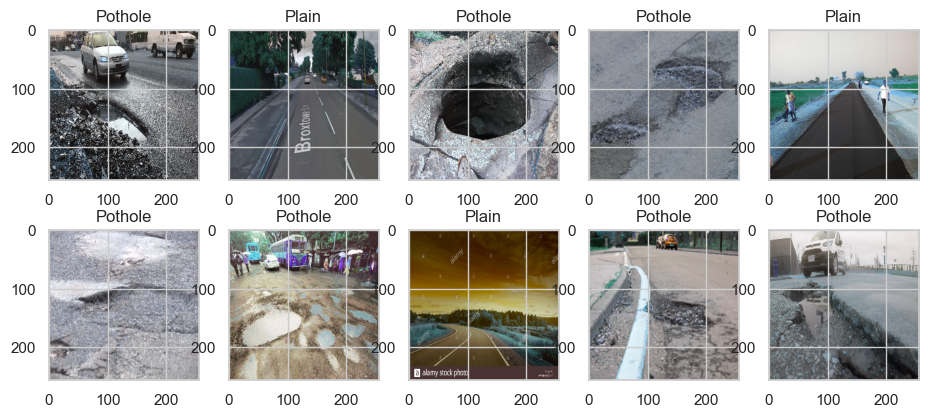

In [6]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(10,10)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

In [7]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
print(Y)
X=np.array(X)

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=1337)

np.random.seed(42)
rn.seed(42)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(256,256,3), pooling='max')
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [9]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.20))
model.add(Dense(2048,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [10]:
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)
base_model.trainable=True # setting the VGG model to be trainable.
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 30,408,066
Trainable params: 30,354,946
No

In [11]:
History = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test))

Epoch 1/50
17/17 [==============================] - 163s 9s/step - loss: 0.8849 - accuracy: 0.7301 - val_loss: 0.3923 - val_accuracy: 0.8398
Epoch 2/50
17/17 [==============================] - 164s 10s/step - loss: 0.1958 - accuracy: 0.9224 - val_loss: 0.2759 - val_accuracy: 0.9227
Epoch 3/50
17/17 [==============================] - 156s 9s/step - loss: 0.1464 - accuracy: 0.9519 - val_loss: 0.3612 - val_accuracy: 0.8895
Epoch 4/50
17/17 [==============================] - 155s 9s/step - loss: 0.0872 - accuracy: 0.9649 - val_loss: 0.2803 - val_accuracy: 0.9227
Epoch 5/50
17/17 [==============================] - 157s 9s/step - loss: 0.0448 - accuracy: 0.9797 - val_loss: 0.2814 - val_accuracy: 0.9227
Epoch 6/50
17/17 [==============================] - 162s 10s/step - loss: 0.0530 - accuracy: 0.9815 - val_loss: 0.2660 - val_accuracy: 0.9227
Epoch 7/50
17/17 [==============================] - 144s 8s/step - loss: 0.0126 - accuracy: 0.9963 - val_loss: 0.2379 - val_accuracy: 0.9282
Epoch 8/50


In [12]:
model.save('model.h5')

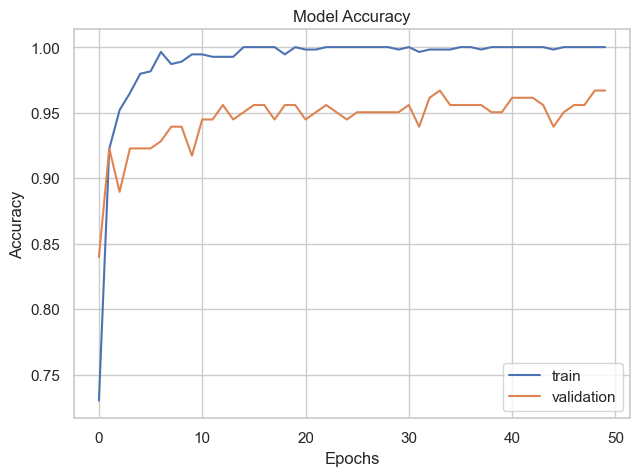

In [13]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

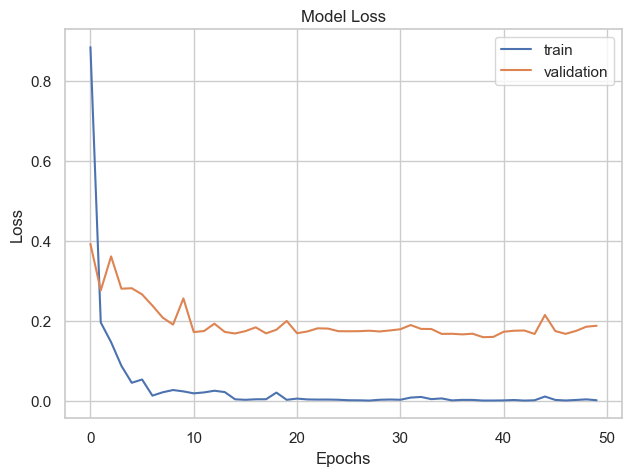

In [14]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [15]:
path = r"Dataset\Pothole\test\Pothole"
files = os.listdir(path)
files

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg']

  0%|          | 0/8 [00:00<?, ?it/s]

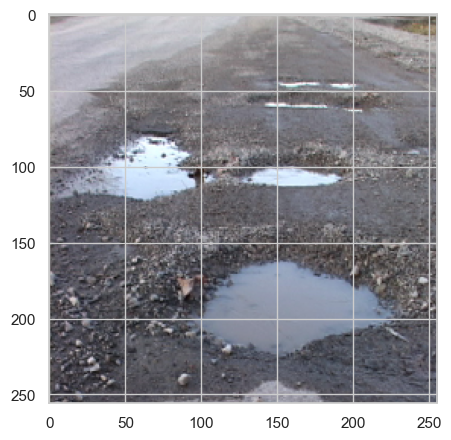

1/1 [==============================] - 1s 941ms/step


 12%|█▎        | 1/8 [00:01<00:08,  1.28s/it]

Pothole Road


1/1 [==============================] - 0s 119ms/step


 25%|██▌       | 2/8 [00:01<00:05,  1.06it/s]

Pothole Road


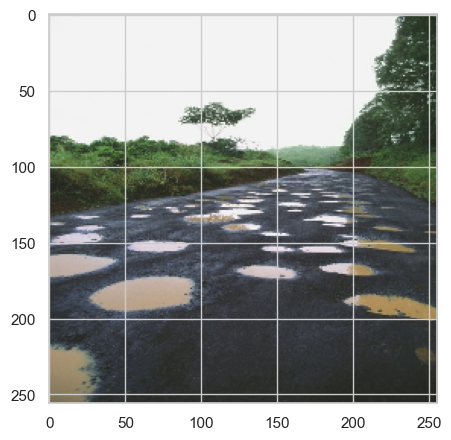

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 3/8 [00:02<00:03,  1.44it/s]

Plain Road


1/1 [==============================] - 0s 116ms/step


 50%|█████     | 4/8 [00:02<00:02,  1.75it/s]

Pothole Road


1/1 [==============================] - 0s 112ms/step


 62%|██████▎   | 5/8 [00:03<00:01,  1.98it/s]

Pothole Road


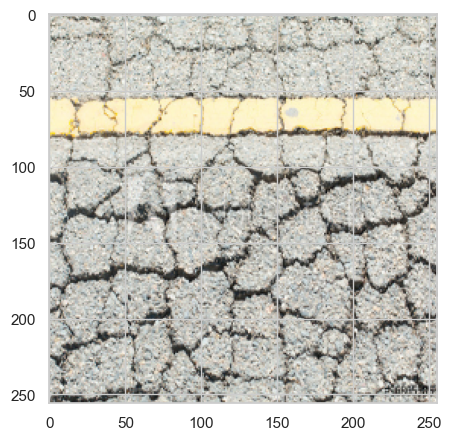

1/1 [==============================] - 0s 109ms/step


 75%|███████▌  | 6/8 [00:03<00:00,  2.21it/s]

Pothole Road


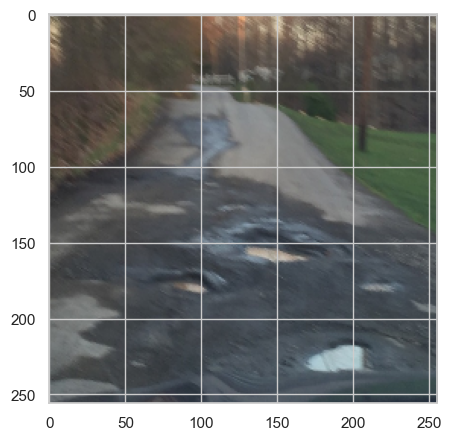

1/1 [==============================] - 0s 108ms/step


 88%|████████▊ | 7/8 [00:03<00:00,  2.33it/s]

Pothole Road


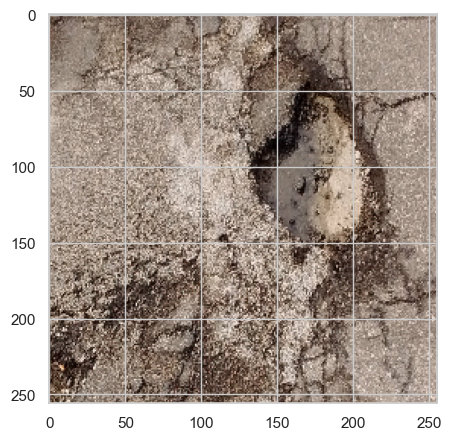

1/1 [==============================] - 0s 113ms/step


100%|██████████| 8/8 [00:04<00:00,  1.87it/s]

Pothole Road


In [16]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1]) 
    plt.show()  

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Plain Road")
    else:
        print("Pothole Road")

In [17]:
path = r"Dataset\Pothole\test\Plain"
files = os.listdir(path)
files

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg']

  0%|          | 0/8 [00:00<?, ?it/s]

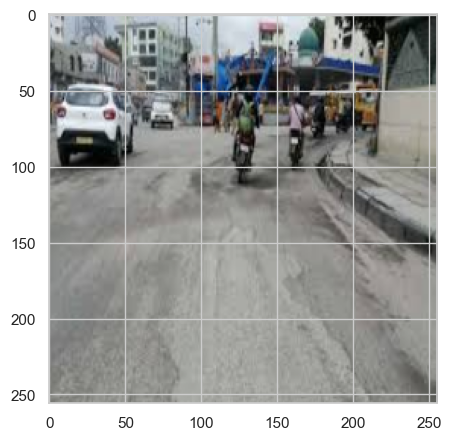

1/1 [==============================] - 0s 116ms/step


 12%|█▎        | 1/8 [00:00<00:03,  2.05it/s]

Pothole Road


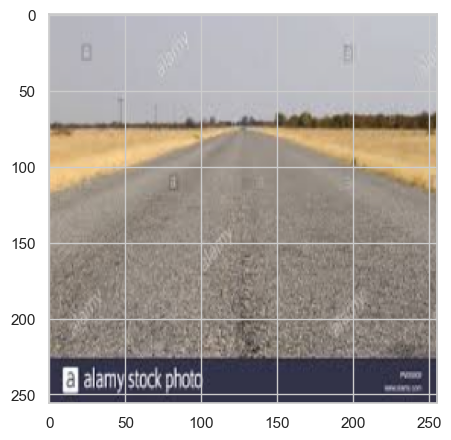

1/1 [==============================] - 0s 103ms/step


 25%|██▌       | 2/8 [00:00<00:02,  2.45it/s]

Plain Road


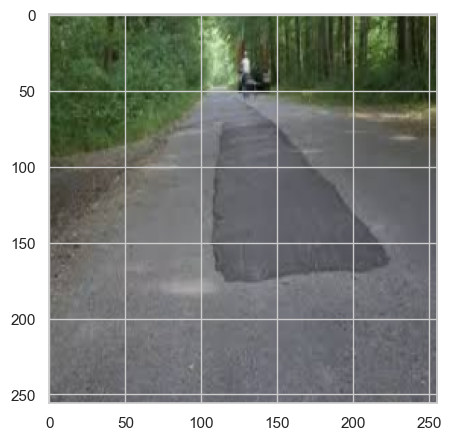

1/1 [==============================] - 0s 107ms/step


 38%|███▊      | 3/8 [00:01<00:01,  2.66it/s]

Plain Road


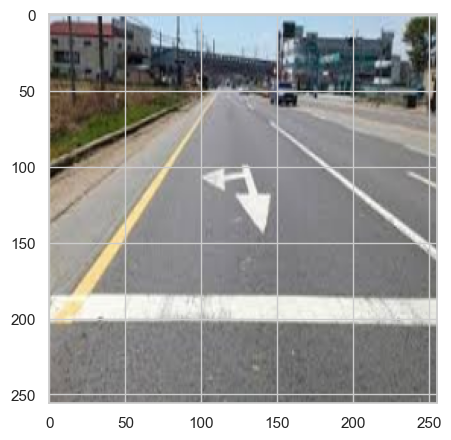

1/1 [==============================] - 0s 106ms/step


 50%|█████     | 4/8 [00:01<00:01,  2.71it/s]

Plain Road


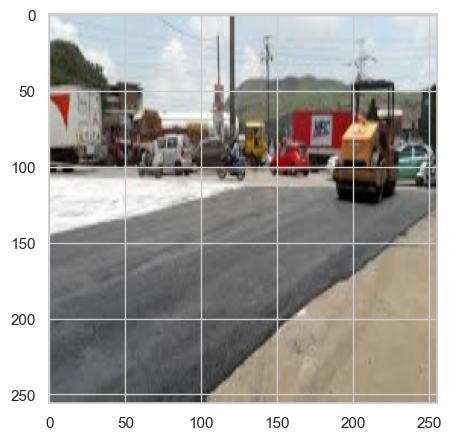

1/1 [==============================] - 0s 109ms/step


 62%|██████▎   | 5/8 [00:01<00:01,  2.77it/s]

Plain Road


1/1 [==============================] - 0s 119ms/step


 75%|███████▌  | 6/8 [00:02<00:00,  2.78it/s]

Plain Road


1/1 [==============================] - 0s 128ms/step


 88%|████████▊ | 7/8 [00:02<00:00,  2.67it/s]

Plain Road


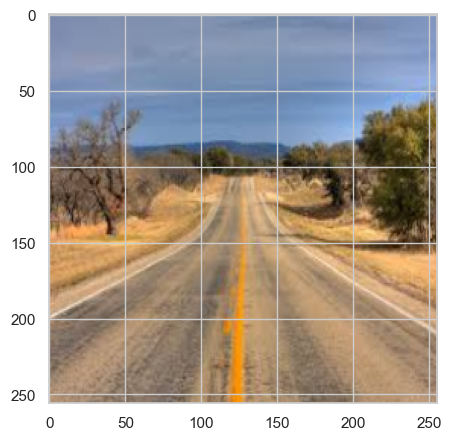

1/1 [==============================] - 0s 119ms/step


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]

Plain Road


In [18]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1]) 
    plt.show()  

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Plain Road")
    else:
        print("Pothole Road")